In [103]:
folder = 'figures/007_dig_into_correlations'
! mkdir $folder

In [104]:
from __future__ import print_function

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from anchor.visualize import MODALITY_TO_COLOR, MODALITY_ORDER, MODALITY_PALETTE
modality_order = MODALITY_ORDER

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline

%load_ext autoreload
%autoreload 2


import flotilla
study = flotilla.embark('singlecell_pnm_figure6_splicing_correlation_permuted', 
                        flotilla_dir='/projects/ps-yeolab/obotvinnik/flotilla_projects/')
# study = flotilla.embark('singlecell_pnm_figure1_supplementary_post_splicing_filtering')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-11-07 11:14:27	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure6_splicing_correlation_permuted/datapackage.json
2016-11-07 11:14:27	Parsing datapackage to create a Study object
https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-11-07 11:16:01 	Initializing Study
2016-11-07 11:16:01 	Initializing Predictor configuration manager for Study
2016-11-07 11:16:01	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-11-07 11:16:01	Added ExtraTreesClassifier to default predictors
2016-11-07 11:16:01	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-11-07 11:16:01	Added ExtraTreesRegressor to default predictors
2016-11-07 11:16:01	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemb

Error loading species hg19 data: HTTP Error 404: Not Found

In [112]:
permuted = study.supplemental.splicing_expression_corr_with_permuted.query('dataset == "Permuted"')
print(permuted.shape)
permuted.head()

(69832000, 4)


,Splicing Gene,level_1,Pearson R,dataset
0,PKM,0,0.141416,Permuted
1,PKM,1,0.028138,Permuted
2,PKM,2,0.021426,Permuted
3,PKM,3,-0.049653,Permuted
4,PKM,4,0.008166,Permuted


In [113]:
means = permuted.groupby(['Splicing Gene'])['Pearson R'].mean()
stds = permuted.groupby(['Splicing Gene'])['Pearson R'].std()


In [114]:
multiplier = 3

In [115]:
lower_bound = means - multiplier*stds
lower_bound

Splicing Gene
PKM           -0.474251
SMARCE1       -0.493314
SNAP25        -0.538973
iteration   -366.524996
Name: Pearson R, dtype: float64

In [116]:
upper_bound = means + multiplier*stds
upper_bound

Splicing Gene
PKM             0.474338
SMARCE1         0.493162
SNAP25          0.538865
iteration    1365.524996
Name: Pearson R, dtype: float64

In [110]:
splicing_genes = 'PKM', 'SMARCE1', 'SNAP25'

In [111]:
correlations = study.supplemental.splicing_expression_corr_with_permuted.query('dataset == "Actual"')
print(correlations.shape)
correlations.head()

(52374, 4)


,Splicing Gene,level_1,Pearson R,dataset
0,PKM,ENSG00000000003,0.050616,Actual
1,PKM,ENSG00000000419,-0.121469,Actual
2,PKM,ENSG00000000457,0.057363,Actual
3,PKM,ENSG00000000460,0.047255,Actual
4,PKM,ENSG00000001036,-0.320053,Actual


In [124]:
def filter_correlations(df):
    splicing_gene = df['Splicing Gene'].iloc[0]
    
    lb = lower_bound[splicing_gene]
    ub = upper_bound[splicing_gene]
    
    below = df['Pearson R'] < lb
    above = df['Pearson R'] > ub
    
    return df.loc[above | below]

correlations_filtered = correlations.groupby('Splicing Gene', as_index=False, group_keys=False).apply(filter_correlations)
print(correlations_filtered.shape)
correlations_filtered.head()

(695, 4)


,Splicing Gene,level_1,Pearson R,dataset
7,PKM,ENSG00000001460,-0.481463,Actual
38,PKM,ENSG00000004399,-0.528088,Actual
100,PKM,ENSG00000006327,-0.520701,Actual
111,PKM,ENSG00000006625,-0.527317,Actual
164,PKM,ENSG00000008394,-0.524712,Actual


In [125]:
correlations_filtered = correlations_filtered.rename(columns={"level_1": 'Expression Gene'})
print(correlations_filtered.shape)
correlations_filtered.head()

(695, 4)


,Splicing Gene,Expression Gene,Pearson R,dataset
7,PKM,ENSG00000001460,-0.481463,Actual
38,PKM,ENSG00000004399,-0.528088,Actual
100,PKM,ENSG00000006327,-0.520701,Actual
111,PKM,ENSG00000006625,-0.527317,Actual
164,PKM,ENSG00000008394,-0.524712,Actual


In [126]:
correlations_filtered_symbols = correlations_filtered.join(study.expression.feature_data['gene_name'], on='Expression Gene')
print(correlations_filtered_symbols.shape)
correlations_filtered_symbols.head()

(695, 5)


,Splicing Gene,Expression Gene,Pearson R,dataset,gene_name
7,PKM,ENSG00000001460,-0.481463,Actual,STPG1
38,PKM,ENSG00000004399,-0.528088,Actual,PLXND1
100,PKM,ENSG00000006327,-0.520701,Actual,TNFRSF12A
111,PKM,ENSG00000006625,-0.527317,Actual,GGCT
164,PKM,ENSG00000008394,-0.524712,Actual,MGST1


In [130]:
def direction(x):
    if x > 0:
        return "Positive (+)"
    else:
        return 'Negative (-)'

correlations_filtered_symbols['Correlation direction'] = correlations_filtered_symbols['Pearson R'].map(direction)
print(correlations_filtered_symbols.shape)
correlations_filtered_symbols.head()

(695, 6)


,Splicing Gene,Expression Gene,Pearson R,dataset,gene_name,Correlation direction
7,PKM,ENSG00000001460,-0.481463,Actual,STPG1,Negative (-)
38,PKM,ENSG00000004399,-0.528088,Actual,PLXND1,Negative (-)
100,PKM,ENSG00000006327,-0.520701,Actual,TNFRSF12A,Negative (-)
111,PKM,ENSG00000006625,-0.527317,Actual,GGCT,Negative (-)
164,PKM,ENSG00000008394,-0.524712,Actual,MGST1,Negative (-)


In [131]:
pkm_filtered_symbols.groupby('Correlation direction').size()

Correlation direction
(+)    132
(-)    228
dtype: int64

In [133]:
for splicing_gene, df in correlations_filtered_symbols.groupby('Splicing Gene'):
    csv = '{}/{}_filtered_correlations.csv'.format(folder, splicing_gene)
    print(csv)
    df.to_csv(csv)

figures/007_dig_into_correlations/PKM_filtered_correlations.csv
figures/007_dig_into_correlations/SMARCE1_filtered_correlations.csv
figures/007_dig_into_correlations/SNAP25_filtered_correlations.csv


In [15]:
# rows = pkm_filtered_symbols['Correlation direction'] == '(+)'

# print(pkm_filtered_symbols.loc[rows, 'Expression Gene'].to_csv(None, index=False))

In [16]:
! grep mygene ../*/*.ipynb

In [17]:
import goatools
import mygene

In [58]:
# Initialize the "mygene.info" (http://mygene.info/) interface
mg = mygene.MyGeneInfo()

mygene_output = mg.querymany(background_genes, 
                             scopes='ensemblgene', 
                             fields=['go.BP', 'go.MF', 'go.CC'], 
                             species='human')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-17458...done.
Finished.
7 input query terms found dup hits:
	[(u'ENSG00000228106', 2), (u'ENSG00000183889', 6), (u'ENSG00000215126', 2), (u'ENSG00000229719', 2),
587 input query terms found no hit:
	[u'ENSG00000005955', u'ENSG00000006114', u'ENSG00000017373', u'ENSG00000017621', u'ENSG00000031544',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [57]:
background_genes = df['level_1'].unique()
len(background_genes)

17458

In [61]:
gene_name_to_go = parse_mygene_output(mygene_output)
len(gene_name_to_go)

12124

In [62]:
gene_name_to_go.keys()[:10]

[u'ENSG00000180008',
 u'ENSG00000167693',
 u'ENSG00000064703',
 u'ENSG00000230873',
 u'ENSG00000189292',
 u'ENSG00000110514',
 u'ENSG00000247077',
 u'ENSG00000086015',
 u'ENSG00000168032',
 u'ENSG00000142686']

In [64]:
mg.querymany(gene_ids, species='human,mouse,rat',
                   scopes='entrezgene,ensemblgene,retired,symbol',
                   fields=GO_KEYS_FULL,)

querying 1-10...done.
Finished.


[{u'_id': u'122809',
  u'_score': 21.914225,
  u'go': {u'BP': [{u'evidence': u'IDA',
     u'id': u'GO:0007175',
     u'pubmed': 15590694,
     u'term': u'negative regulation of epidermal growth factor-activated receptor activity'},
    {u'evidence': u'IEA',
     u'id': u'GO:0016567',
     u'term': u'protein ubiquitination'},
    {u'evidence': u'IBA',
     u'id': u'GO:0019221',
     u'term': u'cytokine-mediated signaling pathway'},
    {u'evidence': u'IEA',
     u'id': u'GO:0032436',
     u'term': u'positive regulation of proteasomal ubiquitin-dependent protein catabolic process'},
    {u'evidence': u'IEA',
     u'id': u'GO:0035556',
     u'term': u'intracellular signal transduction'},
    {u'evidence': u'IEA',
     u'id': u'GO:0040008',
     u'term': u'regulation of growth'},
    {u'evidence': u'IBA',
     u'id': u'GO:0046426',
     u'term': u'negative regulation of JAK-STAT cascade'}],
   u'CC': {u'evidence': u'IBA', u'id': u'GO:0005737', u'term': u'cytoplasm'},
   u'MF': {u'evidence'

In [63]:
gene_ids = [u'ENSG00000180008',
 u'ENSG00000167693',
 u'ENSG00000064703',
 u'ENSG00000230873',
 u'ENSG00000189292',
 u'ENSG00000110514',
 u'ENSG00000247077',
 u'ENSG00000086015',
 u'ENSG00000168032',
 u'ENSG00000142686']

gene_ids_to_go(gene_ids)

querying 1-10...done.
Finished.


defaultdict(set,
            {u'ENSG00000064703': {u'GO:0005634',
              u'GO:0005654',
              u'GO:0005737',
              u'GO:0005829',
              u'GO:0005856',
              u'GO:0016020',
              u'GO:0032797',
              u'GO:0034719',
              u'GO:0090571',
              u'GO:0097504'},
             u'ENSG00000086015': {u'GO:0005737', u'GO:0005886', u'GO:0015630'},
             u'ENSG00000110514': {u'GO:0005737',
              u'GO:0005829',
              u'GO:0005886',
              u'GO:0016021'},
             u'ENSG00000142686': {u'GO:0005515'},
             u'ENSG00000167693': {u'GO:0005634', u'GO:0005737', u'GO:0005829'},
             u'ENSG00000168032': {u'GO:0005886', u'GO:0016021'},
             u'ENSG00000180008': {u'GO:0005737'},
             u'ENSG00000189292': {u'GO:0005576'},
             u'ENSG00000230873': {u'GO:0031110'},
             u'ENSG00000247077': {u'GO:0005739',
              u'GO:0005741',
              u'GO:0016021'}})

In [65]:
asdf = {u'ENSG00000064703': {u'GO:0005634',
              u'GO:0005654',
              u'GO:0005737',
              u'GO:0005829',
              u'GO:0005856',
              u'GO:0016020',
              u'GO:0032797',
              u'GO:0034719',
              u'GO:0090571',
              u'GO:0097504'},
             u'ENSG00000086015': {u'GO:0005737', u'GO:0005886', u'GO:0015630'},
             u'ENSG00000110514': {u'GO:0005737',
              u'GO:0005829',
              u'GO:0005886',
              u'GO:0016021'},
             u'ENSG00000142686': {u'GO:0005515'},
             u'ENSG00000167693': {u'GO:0005634', u'GO:0005737', u'GO:0005829'},
             u'ENSG00000168032': {u'GO:0005886', u'GO:0016021'},
             u'ENSG00000180008': {u'GO:0005737'},
             u'ENSG00000189292': {u'GO:0005576'},
             u'ENSG00000230873': {u'GO:0031110'},
             u'ENSG00000247077': {u'GO:0005739',
              u'GO:0005741',
              u'GO:0016021'}}

In [ ]:
collections.defaultdict()

In [52]:
line = mygene_output[0]
line

{u'_id': u'7105',
 u'_score': 22.94159,
 u'go': {u'BP': [{u'evidence': u'IBA',
    u'id': u'GO:0007166',
    u'term': u'cell surface receptor signaling pathway'},
   {u'evidence': u'IMP',
    u'id': u'GO:0039532',
    u'pubmed': 22908223,
    u'term': u'negative regulation of viral-induced cytoplasmic pattern recognition receptor signaling pathway'},
   {u'evidence': u'IMP',
    u'id': u'GO:0043123',
    u'pubmed': 12761501,
    u'term': u'positive regulation of I-kappaB kinase/NF-kappaB signaling'},
   {u'evidence': u'IDA',
    u'id': u'GO:1901223',
    u'pubmed': 22908223,
    u'term': u'negative regulation of NIK/NF-kappaB signaling'}],
  u'CC': [{u'evidence': u'IBA',
    u'id': u'GO:0005887',
    u'term': u'integral component of plasma membrane'},
   {u'evidence': u'IDA',
    u'id': u'GO:0070062',
    u'pubmed': [19056867, 19199708, 23533145],
    u'term': u'extracellular exosome'}],
  u'MF': [{u'evidence': u'IMP',
    u'id': u'GO:0004871',
    u'pubmed': 12761501,
    u'term': u's

In [53]:
line['go']

{u'BP': [{u'evidence': u'IBA',
   u'id': u'GO:0007166',
   u'term': u'cell surface receptor signaling pathway'},
  {u'evidence': u'IMP',
   u'id': u'GO:0039532',
   u'pubmed': 22908223,
   u'term': u'negative regulation of viral-induced cytoplasmic pattern recognition receptor signaling pathway'},
  {u'evidence': u'IMP',
   u'id': u'GO:0043123',
   u'pubmed': 12761501,
   u'term': u'positive regulation of I-kappaB kinase/NF-kappaB signaling'},
  {u'evidence': u'IDA',
   u'id': u'GO:1901223',
   u'pubmed': 22908223,
   u'term': u'negative regulation of NIK/NF-kappaB signaling'}],
 u'CC': [{u'evidence': u'IBA',
   u'id': u'GO:0005887',
   u'term': u'integral component of plasma membrane'},
  {u'evidence': u'IDA',
   u'id': u'GO:0070062',
   u'pubmed': [19056867, 19199708, 23533145],
   u'term': u'extracellular exosome'}],
 u'MF': [{u'evidence': u'IMP',
   u'id': u'GO:0004871',
   u'pubmed': 12761501,
   u'term': u'signal transducer activity'},
  {u'evidence': u'IPI',
   u'id': u'GO:00055

In [48]:
gene_name_to_go

defaultdict(set, {})

In [66]:
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

# Show the filename
print(obo_fname)

obo_dag = goatools.obo_parser.GODag(obo_file=obo_fname)


  EXISTS: go-basic.obo
go-basic.obo
go-basic.obo: format-version(1.2) data-version(releases/2016-11-07)

load obo file go-basic.obo
47689

 nodes imported


In [140]:
rows = pkm_filtered_symbols['Correlation direction'] == '(+)'

# print(pkm_filtered_symbols.loc[rows, 'Expression Gene'].to_csv(None, index=False))

go_enricher = goatools.GOEnrichmentStudy(background_genes, 
                                         gene_name_to_go, obo_dag)


12,124 out of 17,458 population items found in association


Propagating term counts to parents ..


In [178]:
def run_go(go_enricher, gene_ids, p_cutoff=1, correction='bonferroni'):
    
    results = go_enricher.run_study(gene_ids)
    go_enrichment = pd.DataFrame([r.__dict__ for r in results])

    p_column = 'p_' + correction
    go_enrichment['-log10(q)'] = -np.log10(go_enrichment[p_column])
    go_enrichment = go_enrichment.sort_values('-log10(q)', ascending=False)

#     rows = go_enrichment[p_column] < p_cutoff
#     go_enrichment_filtered = go_enrichment.loc[rows]
    
    return go_enrichment

In [148]:
go_enrichment = run_go(go_enricher, pkm_filtered_symbols.loc[rows, 'Expression Gene'])
print(go_enrichment.shape)
go_enrichment.head()

Calculating uncorrected p-values using Fisher's exact test
    75 out of    132 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: local holm
2,432 GO terms are associated with 75 of 132 study items in a population of 17,458
(2432, 18)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n
0,GO:0060060,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0060060\tlevel-03\tdepth-04\tpost-embryonic...,post-embryonic retina morphogenesis in camera-...,1.0,1.0,1.0,0.007561,1,{ENSG00000180376},17458,"(1, 17458)","(1, 132)",1,{ENSG00000180376},132
1,GO:0048666,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0048666\tlevel-04\tdepth-05\tneuron develop...,neuron development,1.0,1.0,1.0,0.007561,1,{ENSG00000180376},17458,"(1, 17458)","(1, 132)",1,{ENSG00000180376},132
2,GO:0009582,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0009582\tlevel-03\tdepth-03\tdetection of a...,detection of abiotic stimulus,1.0,1.0,1.0,0.007561,1,{ENSG00000180376},17458,"(1, 17458)","(1, 132)",1,{ENSG00000180376},132
3,GO:0009583,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0009583\tlevel-04\tdepth-05\tdetection of l...,detection of light stimulus,1.0,1.0,1.0,0.007561,1,{ENSG00000180376},17458,"(1, 17458)","(1, 132)",1,{ENSG00000180376},132
4,GO:0009584,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0009584\tlevel-05\tdepth-06\tdetection of v...,detection of visible light,1.0,1.0,1.0,0.007561,1,{ENSG00000180376},17458,"(1, 17458)","(1, 132)",1,{ENSG00000180376},132


In [159]:
go_enrichment.query('p_bonferroni < 1')

,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n
450,GO:0043005,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0043005\tlevel-03\tdepth-03\tneuron project...,neuron projection,0.116587,0.116587,0.113649,0.000048,529,"{ENSG00000080815, ENSG00000154134, ENSG0000014...",17458,"(529, 17458)","(14, 132)",14,"{ENSG00000131711, ENSG00000172020, ENSG0000014...",132
451,GO:0097458,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0097458\tlevel-02\tdepth-02\tneuron part [c...,neuron part,0.609196,0.608945,0.593842,0.000250,939,"{ENSG00000080815, ENSG00000154134, ENSG0000004...",17458,"(939, 17458)","(18, 132)",18,"{ENSG00000131711, ENSG00000183813, ENSG0000017...",132


In [92]:
go_enrichment_top = go_enrichment.iloc[:10]
print(go_enrichment_top.shape)
go_enrichment_top.head()

(10, 19)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n,-log10(q)
450,GO:0005913,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0005913\tlevel-03\tdepth-04\tcell-cell adhe...,cell-cell adherens junction,1.103045e-07,1.103045e-07,1.075245e-07,4.535549e-11,294,"{ENSG00000110841, ENSG00000120265, ENSG0000013...",17458,"(294, 17458)","(23, 228)",23,"{ENSG00000011426, ENSG00000074181, ENSG0000015...",228,6.957407
451,GO:0005912,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0005912\tlevel-03\tdepth-03\tadherens junct...,adherens junction,1.316019e-07,1.315478e-07,1.282851e-07,5.411264e-11,597,"{ENSG00000137312, ENSG00000167699, ENSG0000013...",17458,"(597, 17458)","(37, 228)",37,"{ENSG00000011426, ENSG00000074181, ENSG0000015...",228,6.880738
452,GO:0005911,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0005911\tlevel-02\tdepth-02\tcell-cell junc...,cell-cell junction,1.362597e-07,1.361477e-07,1.328255e-07,5.602785e-11,490,"{ENSG00000137312, ENSG00000167699, ENSG0000013...",17458,"(490, 17458)","(30, 228)",30,"{ENSG00000011426, ENSG00000074181, ENSG0000015...",228,6.865633
453,GO:0070161,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0070161\tlevel-02\tdepth-02\tanchoring junc...,anchoring junction,1.993777e-07,1.991317e-07,1.943527e-07,8.198095e-11,607,"{ENSG00000137312, ENSG00000167699, ENSG0000013...",17458,"(607, 17458)","(39, 228)",39,"{ENSG00000011426, ENSG00000074181, ENSG0000015...",228,6.700323
454,GO:0030054,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0030054\tlevel-01\tdepth-01\tcell junction ...,cell junction,3.046528e-07,3.041517e-07,2.969745e-07,1.252684e-10,1028,"{ENSG00000080815, ENSG00000137312, ENSG0000016...",17458,"(1028, 17458)","(44, 228)",44,"{ENSG00000011426, ENSG00000074181, ENSG0000015...",228,6.516195


In [96]:
go_enrichment_top = go_enrichment_top.iloc[::-1]
go_enrichment_top.head()

,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n,-log10(q)
459,GO:0044422,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0044422\tlevel-01\tdepth-01\torganelle part...,organelle part,4.973248e-07,4.954843e-07,4.847905e-07,2.044921e-10,6557,"{ENSG00000064703, ENSG00000247077, ENSG0000016...",17458,"(6557, 17458)","(141, 228)",141,"{ENSG00000051596, ENSG00000182871, ENSG0000019...",228,6.303360
458,GO:0044424,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0044424\tlevel-02\tdepth-02\tintracellular ...,intracellular part,4.829476e-07,4.813590e-07,4.707757e-07,1.985804e-10,10036,"{ENSG00000180008, ENSG00000167693, ENSG0000006...",17458,"(10036, 17458)","(183, 228)",183,"{ENSG00000051596, ENSG00000182871, ENSG0000019...",228,6.316100
457,GO:0044464,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0044464\tlevel-01\tdepth-01\tcell part [cel...,cell part,4.820975e-07,4.807099e-07,4.699470e-07,1.982309e-10,10938,"{ENSG00000180008, ENSG00000167693, ENSG0000006...",17458,"(10938, 17458)","(194, 228)",194,"{ENSG00000051596, ENSG00000163249, ENSG0000018...",228,6.316865
456,GO:0044446,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0044446\tlevel-02\tdepth-03\tintracellular ...,intracellular organelle part,4.269935e-07,4.259400e-07,4.162318e-07,1.755730e-10,6445,"{ENSG00000064703, ENSG00000247077, ENSG0000016...",17458,"(6445, 17458)","(138, 228)",138,"{ENSG00000051596, ENSG00000182871, ENSG0000019...",228,6.369579
455,GO:0005575,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0005575\tlevel-00\tdepth-00\tcellular_compo...,cellular_component,3.367583e-07,3.360660e-07,3.282709e-07,1.384697e-10,11716,"{ENSG00000180008, ENSG00000167693, ENSG0000006...",17458,"(11716, 17458)","(202, 228)",202,"{ENSG00000051596, ENSG00000163249, ENSG0000018...",228,6.472682


In [98]:
sns.set(context='paper', style='whitegrid')

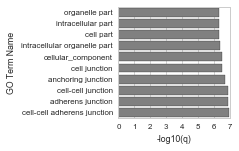

In [102]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.barplot(x='-log10(q)', y='name', data=go_enrichment_top, color='grey')
ax.set(xlabel='-log10(q)', ylabel='GO Term Name')


## Make GO functions

In [271]:
import collections
import mygene


GO_KEYS_FULL = 'go.BP', 'go.MF', 'go.CC'
GO_KEYS_SPLIT = [x.split('.')[1] for x in GO_KEYS_FULL]


def parse_mygene_output(mygene_output):
    """Convert mygene.querymany output to a gene id to go term mapping (dictionary)

    Parameters
    ----------
    mygene_output : dict or list
        Dictionary (returnall=True) or list (returnall=False) of
        output from mygene.querymany

    Output
    ------
    gene_name_to_go : dict
        Mapping of gene name to a set of GO ids
    """
    # if "returnall=True" was specified, need to get just the "out" key
    if isinstance(mygene_output, dict):
        mygene_output = mygene_output['out']

    gene_name_to_go = collections.defaultdict(set)

    for line in mygene_output:
        gene_name = line['query']
        try:
            go_output = line['go']
        except KeyError:
            continue
        for go_key in GO_KEYS_SPLIT:
            try:
                go_terms = go_output[go_key]
            except KeyError:
                continue
            if isinstance(go_terms, dict):
                go_ids = set([go_terms['id']])
            else:
                go_ids = set(x['id'] for x in go_terms)
        gene_name_to_go[gene_name] |= go_ids
    return gene_name_to_go


def gene_ids_to_go(gene_ids, species='human,mouse,rat',
                   scopes='entrezgene,ensemblgene,retired,symbol',
                   fields=GO_KEYS_FULL,
                   **kwargs):
    """Get associated GO terms for each gene ID

    gene_ids : iterable of ids
        List of gene ids that you want to map
    species : str
        Comma-separated species to limit search. Default is "human,mouse,rat"
    scopes : str
        Comma-separated type of gene ids that you are giving.
        Default is "entrezgene,ensemblgene,retired,symbol"
    fields : iterable
        GO terms to use. Default is ['go.BP', 'go.MF', 'go.CC']

    Returns
    -------
    gene_to_go : dict
        Mapping of each provided gene id to a set object of GO terms
    """

    mg = mygene.MyGeneInfo()

    mygene_output = mg.querymany(gene_ids, fields=fields, scopes=scopes,
                                 species=species, **kwargs)

    gene_name_to_go = parse_mygene_output(mygene_output)
    return gene_name_to_go


In [272]:
from goatools.base import download_go_basic_obo

def make_go_enricher(background_genes, species='human,mouse,rat',
                   scopes='entrezgene,ensemblgene,retired,symbol',
                   fields=GO_KEYS_FULL):
    obo_fname = download_go_basic_obo()

    obo_dag = goatools.obo_parser.GODag(obo_file=obo_fname)

    gene_to_go = gene_ids_to_go(background_genes, species, scopes, fields)
    go_enricher = goatools.GOEnrichmentStudy(background_genes, 
                                         gene_to_go, obo_dag)
    return go_enricher

## Run GO ENrichment on all subsets

Use only biological process (`"GO.bp"`)

In [274]:
len(background_genes)

17458

In [275]:
go_enricher = make_go_enricher(background_genes, fields='go.BP', species='human', scopes='ensemblgene')

  EXISTS: go-basic.obo
go-basic.obo: format-version(1.2) data-version(releases/2016-11-07)

load obo file go-basic.obo
47689


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-17458...done.
Finished.

 nodes imported
Propagating term counts to parents ..


7 input query terms found dup hits:
	[(u'ENSG00000228106', 2), (u'ENSG00000183889', 6), (u'ENSG00000215126', 2), (u'ENSG00000229719', 2),
587 input query terms found no hit:
	[u'ENSG00000005955', u'ENSG00000006114', u'ENSG00000017373', u'ENSG00000017621', u'ENSG00000031544',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
11,138 out of 17,458 population items found in association


In [269]:
sns.set(style='whitegrid', context='paper')

In [270]:
for (splicing_gene, direction), df in correlations_filtered_symbols.groupby(['Splicing Gene', 'Correlation direction']):
    go_results = run_go(go_enricher, df['Expression Gene'].values)
    print(splicing_gene, direction, go_results.shape)

    # IF all have p-value = 1... then at least filter for ones that appeared more than once
    if (go_results['-log10(q)'] <= 0).all():
        go_results = go_results.query('study_count > 1')
    else:
        rows = go_results['-log10(q)'] > 0
        go_results = go_results.loc[rows]

    go_results_top = go_results.iloc[:10]
    print(splicing_gene, direction, go_results_top.shape)
    
    go_results_top = go_results_top.iloc[::-1]
    
    
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.barplot(x='-log10(q)', y='name', data=go_results_top, color='grey')
    
    title = '{} {}'.format(splicing_gene, direction)
    ax.set(xlabel='-log10(q)', ylabel='GO Term Name', title=title)
    

Calculating uncorrected p-values using Fisher's exact test
     0 out of    228 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: local holm
0 GO terms are associated with 0 of 228 study items in a population of 17,458


KeyError: 'p_bonferroni'

## Run GO on correlated subsets of genes

In [190]:
motor_neurons_metadata = study.metadata.data.query('(phenotype == "MN") & (single == True)')
print(motor_neurons_metadata.shape)
motor_neurons_metadata.head()

(70, 10)


,single,pooled,phenotype,neuron,progenitor,stressed,craig_venter,differentiation_batch,split,outlier
M1_01,True,False,MN,True,False,False,True,batch1,NaN,False
M1_02,True,False,MN,True,False,False,True,batch1,NaN,False
M1_03,True,False,MN,True,False,False,True,batch1,NaN,True
M1_04,True,False,MN,True,False,False,True,batch1,NaN,True
M1_05,True,False,MN,True,False,False,True,batch1,NaN,False


In [191]:
outlier_colors = pd.Series(['lightgrey' if x else 'black' for x in motor_neurons_metadata['outlier']], 
                           index=motor_neurons_metadata.index)
outlier_colors[:5]

M1_01        black
M1_02        black
M1_03    lightgrey
M1_04    lightgrey
M1_05        black
dtype: object

In [192]:
motor_neurons_expression = study.expression.data.loc[motor_neurons_metadata.index]
print(motor_neurons_expression.shape)
motor_neurons_expression.head()

(70, 18594)


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,...,ENSGR0000185960,ENSGR0000197976,ENSGR0000198223,ENSGR0000205755,ENSGR0000214717,ENSGR0000223511,ENSGR0000226179,ENSGR0000236017,ENSGR0000236871,ENSGR0000270726
M1_01,0.000000,0.0,0.000000,0.476305,0.000000,0.000000,4.086611,0.000000,0.000000,6.805999,...,1.033579,0.000000,1.617492,0.443870,0.000000,0.154009,3.953973,0.000000,0.311817,0.082292
M1_02,6.507290,0.0,0.301184,2.747011,0.828363,1.171047,2.274019,6.534786,0.000000,1.697779,...,3.010307,0.000000,1.984850,1.118778,1.285161,1.246718,2.112323,0.000000,1.321778,0.000000
M1_03,8.520717,0.0,3.096142,2.255833,0.273850,5.306422,0.000000,0.000000,2.916491,0.441541,...,1.246802,2.717079,0.876316,0.559106,0.668499,0.550331,1.485530,0.183634,0.599407,0.267827
M1_04,4.099649,0.0,6.403888,3.715348,2.165648,0.000000,0.123868,0.336502,3.590614,0.000000,...,0.635299,6.343943,0.528861,0.000000,0.508210,0.000000,1.393207,0.000000,0.000000,0.000000
M1_05,0.225582,0.0,0.000000,1.210401,0.000000,0.000000,0.000000,0.000000,0.000000,2.950399,...,1.916381,0.000000,1.611869,0.517444,0.830031,0.409054,0.000000,0.105560,1.425287,0.000000


In [ ]:
for splicing_gene, df in correlations_filtered_symbols.groupby(['Splicing Gene']):
    expression_subset = 

    

In [193]:
pkm_event = 'exon:chr15:72499069-72499221:-@exon:chr15:72495363-72495529:-@exon:chr15:72494795-72494961:-@exon:chr15:72492815-72492996:-'
snap25_event = 'exon:chr20:10265372-10265420:+@exon:chr20:10273530-10273647:+@exon:chr20:10273809-10273926:+@exon:chr20:10277573-10277698:+'
smarce1_event = 'exon:chr17:38801828-38801871:-@exon:chr17:38798707-38798811:-@exon:chr17:38793744-38793824:-'

splicing_events = {'PKM': pkm_event, 'SNAP25': snap25_event, 'SMARCE1': smarce1_event}
splicing_to_correlate = pd.DataFrame(dict((gene, study.splicing.data.loc[motor_neurons_metadata.index, event_id].dropna()) 
                                          for gene, event_id in splicing_events.items()))
print(splicing_to_correlate.shape)
splicing_to_correlate.head()

(54, 3)


,PKM,SMARCE1,SNAP25
M1_01,0.0,NaN,0.157191
M1_02,1.0,0.416667,0.601103
M1_03,0.0,1.000000,NaN
M1_04,0.0,1.000000,NaN
M1_05,0.0,NaN,NaN


In [196]:
import matplotlib as mpl

cmap = mpl.cm.RdYlBu_r

(360, 41)
(300, 38)
(35, 32)


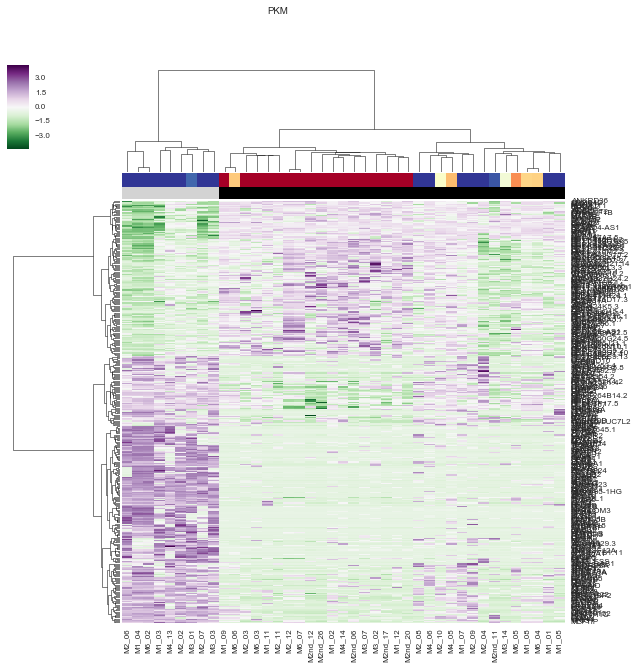

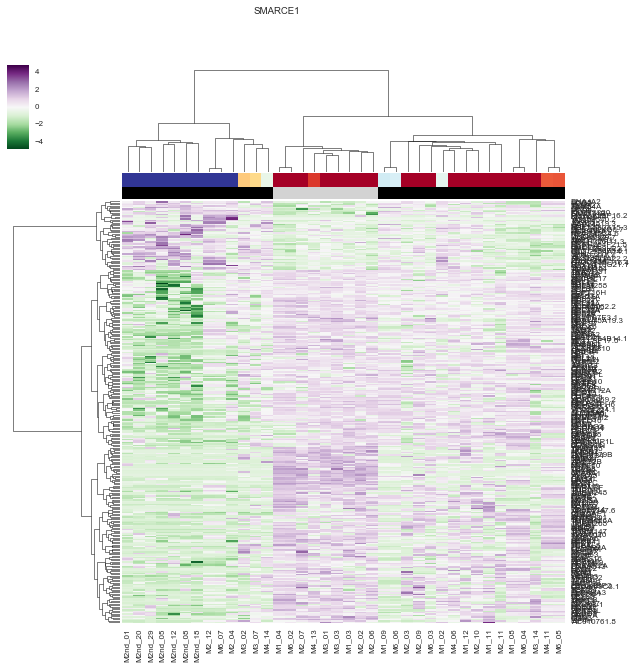

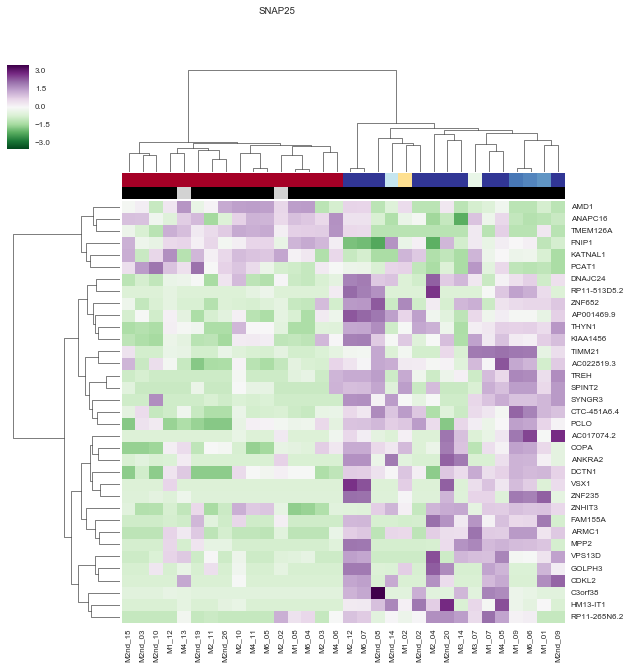

In [222]:
clustergrids = {}

for splicing_gene, df in correlations_filtered_symbols.groupby(['Splicing Gene']):

    gene_ids = df['Expression Gene']
    
    splicing = splicing_to_correlate[splicing_gene].dropna()
    
    subset = motor_neurons_expression.loc[splicing.index, gene_ids]
    yticklabels = study.expression.feature_data.loc[subset.columns, 'gene_name']
    subset = subset.T
    print(subset.shape)
    
    psi_color = [cmap(float(splicing[sample_id])) for sample_id in subset.columns]
    side_colors = [psi_color, outlier_colors[subset.columns]]
    
    g = sns.clustermap(subset, col_colors=side_colors, method='ward', z_score=0,
                       cmap='PRGn_r', yticklabels=yticklabels)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    g.fig.suptitle(splicing_gene)
    g.savefig('{folder}/{splicing_gene}_correlated_genes_clustermap_zscores.pdf'.format(
            folder=folder, splicing_gene=splicing_gene))
    
    clustergrids[splicing_gene] = g

In [234]:
from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter
from scipy.cluster.hierarchy import dendrogram

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

def get_cluster_limits(den):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_limits = Clusters()
    for c in cluster_idxs:
        cluster_limits[c] = (min(cluster_idxs[c]), max(cluster_idxs[c]))
    
    return cluster_limits

In [235]:
g = clustergrids['PKM']

In [236]:
import itertools

palette = map(mpl.colors.rgb2hex, sns.color_palette('Dark2', n_colors=8))
palette_cycle = itertools.cycle(palette)

def color_function(x):
    return palette[x]

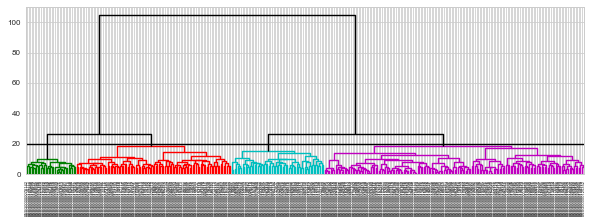

In [239]:
fig, ax = plt.subplots(figsize=(10, 3))
thr = 20
cden = dendrogram(g.dendrogram_row.linkage, color_threshold=thr, 
                  labels=g.data2d.index, above_threshold_color='k')#, link_color_func=color_function);
plt.axhline(thr, color='k');
plt.xticks(rotation=90, fontsize=4);

In [245]:
clusters = get_cluster_classes(cden)
# clusters

Calculating uncorrected p-values using Fisher's exact test
    47 out of     63 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: local holm
2,432 GO terms are associated with 44 of 63 study items in a population of 17,458
---- all p values are 0
SNAP25 Negative (-) (10, 19)
Calculating uncorrected p-values using Fisher's exact test
    91 out of    101 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: local holm
2,432 GO terms are associated with 90 of 101 study items in a population of 17,458
--- at least some significance
SNAP25 Negative (-) (10, 19)
Calculating uncorrected p-values using Fisher's exact test
   122 out of    169 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: loca

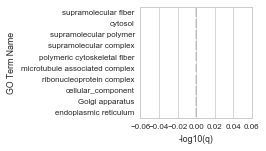

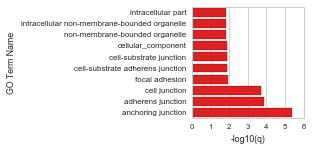

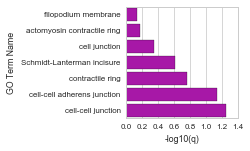

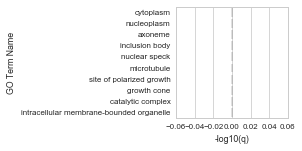

In [258]:
for color, cluster_genes in clusters.items():
    go_results = run_go(go_enricher, cluster_genes)

    # IF all have p-value = 1... then at least filter for ones that appeared more than once
    if (go_results['-log10(q)'] <= 0).all():
        print('---- all p values are 0')
        go_results = go_results.query('study_count > 1')
    else:
        print('--- at least some significance')
        rows = go_results['-log10(q)'] > 0
        go_results = go_results.loc[rows]
        
    if go_results.empty:
        continue

    go_results_top = go_results.iloc[:10]
    print(splicing_gene, direction, go_results_top.shape)
    
    go_results_top = go_results_top.iloc[::-1]
    
    
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.barplot(x='-log10(q)', y='name', data=go_results_top, color=color)
    
#     title = '{} {}'.format(splicing_gene, direction)
    ax.set(xlabel='-log10(q)', ylabel='GO Term Name')

In [260]:
cluster_genes = clusters['c']
go_results = run_go(go_enricher, cluster_genes)
go_results


Calculating uncorrected p-values using Fisher's exact test
    47 out of     63 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: local holm
2,432 GO terms are associated with 44 of 63 study items in a population of 17,458


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n,-log10(q)
0,GO:0060060,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0060060\tlevel-03\tdepth-04\tpost-embryonic...,post-embryonic retina morphogenesis in camera-...,1.0,1.0,1.0,0.003609,1,{ENSG00000180376},17458,"(1, 17458)","(1, 63)",1,{ENSG00000180376},63,-0.0
1624,GO:0005783,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0005783\tlevel-04\tdepth-05\tendoplasmic re...,endoplasmic reticulum,1.0,1.0,1.0,1.000000,642,"{ENSG00000080815, ENSG00000136770, ENSG0000017...",17458,"(642, 17458)","(2, 63)",2,"{ENSG00000028116, ENSG00000120742}",63,-0.0
1617,GO:0043190,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0043190\tlevel-04\tdepth-05\tATP-binding ca...,ATP-binding cassette (ABC) transporter complex,1.0,1.0,1.0,1.000000,7,"{ENSG00000197150, ENSG00000119688, ENSG0000013...",17458,"(7, 17458)","(0, 63)",0,{},63,-0.0
1618,GO:0043194,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0043194\tlevel-04\tdepth-04\taxon initial s...,axon initial segment,1.0,1.0,1.0,1.000000,9,"{ENSG00000196876, ENSG00000075043, ENSG0000014...",17458,"(9, 17458)","(0, 63)",0,{},63,-0.0
1619,GO:0043198,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0043198\tlevel-03\tdepth-03\tdendritic shaf...,dendritic shaft,1.0,1.0,1.0,1.000000,23,"{ENSG00000080815, ENSG00000196924, ENSG0000011...",17458,"(23, 17458)","(0, 63)",0,{},63,-0.0
1620,GO:0097504,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0097504\tlevel-06\tdepth-07\tGemini of coil...,Gemini of coiled bodies,1.0,1.0,1.0,1.000000,11,"{ENSG00000064703, ENSG00000205571, ENSG0000010...",17458,"(11, 17458)","(0, 63)",0,{},63,-0.0
1621,GO:0005784,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0005784\tlevel-04\tdepth-06\tSec61 transloc...,Sec61 translocon complex,1.0,1.0,1.0,1.000000,4,"{ENSG00000185825, ENSG00000170540, ENSG0000010...",17458,"(4, 17458)","(0, 63)",0,{},63,-0.0
1622,GO:0005785,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0005785\tlevel-03\tdepth-05\tsignal recogni...,signal recognition particle receptor complex,1.0,1.0,1.0,1.000000,4,"{ENSG00000144867, ENSG00000143742, ENSG0000016...",17458,"(4, 17458)","(0, 63)",0,{},63,-0.0
1623,GO:0005782,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0005782\tlevel-05\tdepth-06\tperoxisomal ma...,peroxisomal matrix,1.0,1.0,1.0,1.000000,31,"{ENSG00000140876, ENSG00000018510, ENSG0000013...",17458,"(31, 17458)","(0, 63)",0,{},63,-0.0
1625,GO:1990635,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:1990635\tlevel-03\tdepth-03\tproximal dendr...,proximal dendrite,1.0,1.0,1.0,1.000000,2,"{ENSG00000169282, ENSG00000011485}",17458,"(2, 17458)","(0, 63)",0,{},63,-0.0


In [255]:
(go_results['-log10(q)'] <= 0).all()

True

In [261]:
go_results = go_results.query('study_count > 1')
print(go_results.shape)
go_results.head()

(96, 19)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n,-log10(q)
1624,GO:0005783,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0005783\tlevel-04\tdepth-05\tendoplasmic re...,endoplasmic reticulum,1.0,1.0,1.0,1.000000,642,"{ENSG00000080815, ENSG00000136770, ENSG0000017...",17458,"(642, 17458)","(2, 63)",2,"{ENSG00000028116, ENSG00000120742}",63,-0.0
1679,GO:0005794,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0005794\tlevel-04\tdepth-05\tGolgi apparatu...,Golgi apparatus,1.0,1.0,1.0,1.000000,633,"{ENSG00000080815, ENSG00000176049, ENSG0000012...",17458,"(633, 17458)","(2, 63)",2,"{ENSG00000108821, ENSG00000138031}",63,-0.0
1724,GO:0005575,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0005575\tlevel-00\tdepth-00\tcellular_compo...,cellular_component,1.0,1.0,1.0,1.000000,11716,"{ENSG00000180008, ENSG00000167693, ENSG0000006...",17458,"(11716, 17458)","(42, 63)",42,"{ENSG00000131711, ENSG00000184434, ENSG0000019...",63,-0.0
2079,GO:1990904,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:1990904\tlevel-02\tdepth-02\tribonucleoprot...,ribonucleoprotein complex,1.0,1.0,1.0,1.000000,683,"{ENSG00000233927, ENSG00000164934, ENSG0000009...",17458,"(683, 17458)","(2, 63)",2,"{ENSG00000137154, ENSG00000120742}",63,-0.0
450,GO:0005875,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0005875\tlevel-03\tdepth-05\tmicrotubule as...,microtubule associated complex,1.0,1.0,1.0,0.000984,122,"{ENSG00000197892, ENSG00000115423, ENSG0000016...",17458,"(122, 17458)","(4, 63)",4,"{ENSG00000131711, ENSG00000078018, ENSG0000013...",63,-0.0


In [262]:
go_results = go_results.sort_values('study_count', ascending=False)
go_results.head()

,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n,-log10(q)
1724,GO:0005575,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0005575\tlevel-00\tdepth-00\tcellular_compo...,cellular_component,1.0,1.0,1.0,1.000000,11716,"{ENSG00000180008, ENSG00000167693, ENSG0000006...",17458,"(11716, 17458)","(42, 63)",42,"{ENSG00000131711, ENSG00000184434, ENSG0000019...",63,-0.0
662,GO:0044464,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0044464\tlevel-01\tdepth-01\tcell part [cel...,cell part,1.0,1.0,1.0,0.794393,10938,"{ENSG00000180008, ENSG00000167693, ENSG0000006...",17458,"(10938, 17458)","(41, 63)",41,"{ENSG00000131711, ENSG00000184434, ENSG0000019...",63,-0.0
663,GO:0044424,CC,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0044424\tlevel-02\tdepth-02\tintracellular ...,intracellular part,1.0,1.0,1.0,0.798988,10036,"{ENSG00000180008, ENSG00000167693, ENSG0000006...",17458,"(10036, 17458)","(35, 63)",35,"{ENSG00000131711, ENSG00000184434, ENSG0000019...",63,-0.0
666,GO:0043226,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0043226\tlevel-01\tdepth-01\torganelle [cel...,organelle,1.0,1.0,1.0,0.900009,7908,"{ENSG00000167693, ENSG00000064703, ENSG0000008...",17458,"(7908, 17458)","(29, 63)",29,"{ENSG00000131711, ENSG00000197956, ENSG0000018...",63,-0.0
536,GO:0044444,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0044444\tlevel-03\tdepth-03\tcytoplasmic pa...,cytoplasmic part,1.0,1.0,1.0,0.144832,6119,"{ENSG00000167693, ENSG00000064703, ENSG0000011...",17458,"(6119, 17458)","(28, 63)",28,"{ENSG00000131711, ENSG00000197956, ENSG0000017...",63,-0.0
